In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
random.seed(45)

print(tf.__version__)

2.19.0


In [ ]:
import glob
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
ImageFile.LOAD_TRUNCATED_IMAGES = True

**LOAD IMAGE DATA AND UNDERSTANDING SOME PROPERTIES OF IMAGE**

In [3]:
def image_properties(path):
    for img in random.sample(os.listdir(path),1):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img),cv.IMREAD_COLOR)
        break
        
    return image

Image name = 103292.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 120.33
The standard deviation is 69.71


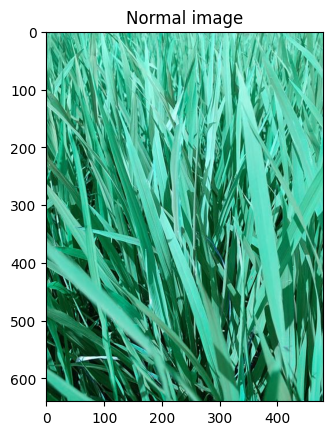

In [4]:
HOME_PATH = os.getcwd() + "/"

path = HOME_PATH + 'train_images/normal'

image = image_properties(path)
plt.imshow(image)
plt.title('Normal image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

**Loading a dataset**

In [5]:
batch_size = 64
img_height = 256
img_width =  256

data_dir = HOME_PATH + 'train_images'

**Image Data-Generator**

**Data Normalization And Data Augmentation**

In [6]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

**Training Dataset (70%)**

In [7]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


**Testing Dataset (30%)**

In [8]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


**Class Lables**

In [9]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


**Displaying a 9 Random images form dataset**

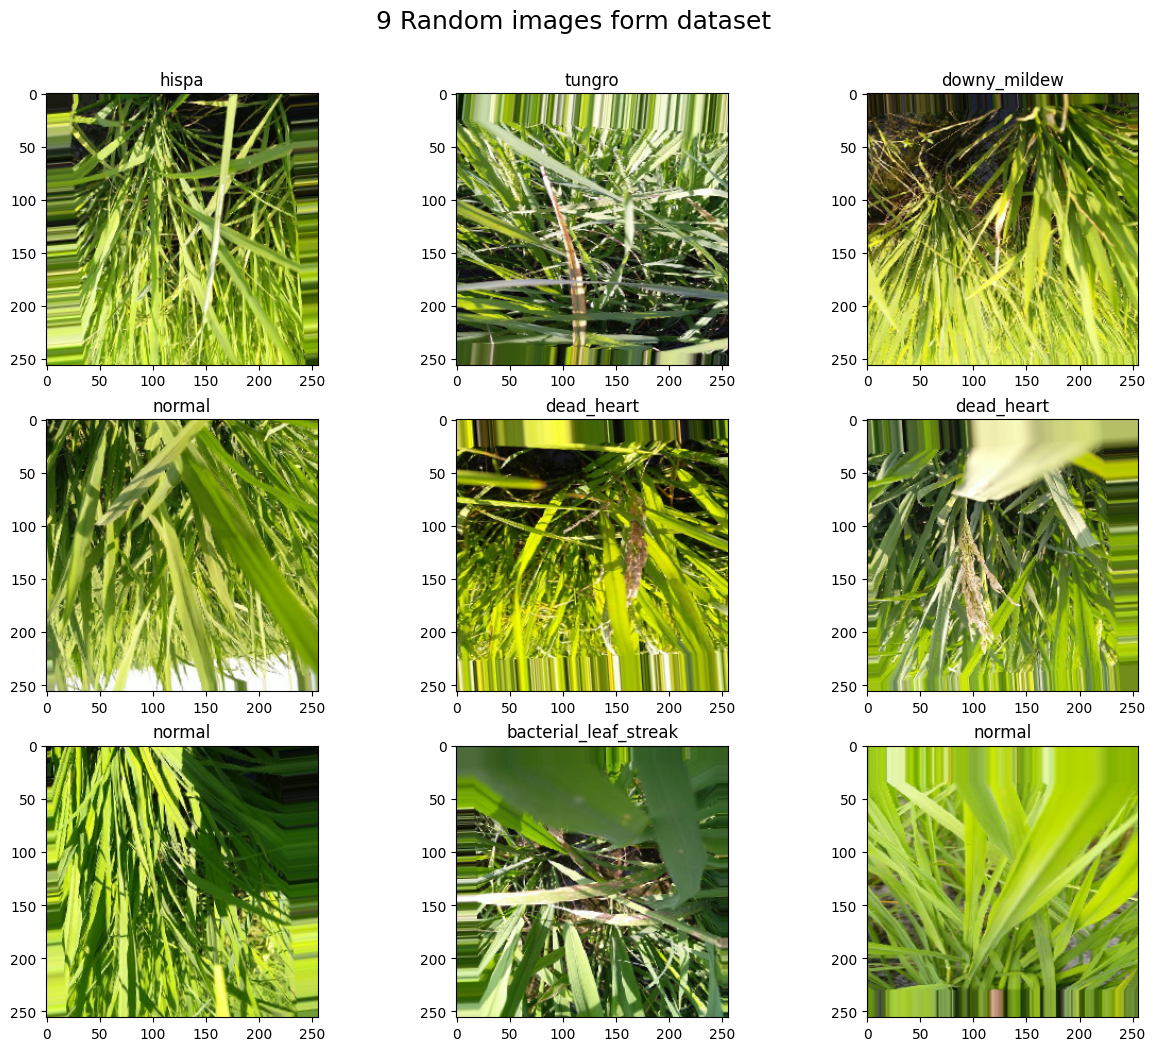

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.__next__()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])

**Vision Transformer (ViT)**

#### REF: `https://keras.io/examples/vision/image_classification_with_vision_transformer/`

In [11]:
# loads an image and convert them to numpy array
def load_images(paths):
  data = []
  labels = []
  i = 0
  for label, path in tqdm(enumerate(paths)):
    for img_path in os.listdir(path):
      image = np.array(Image.open(os.path.join(path,img_path)).convert('RGB').resize((256,256)))
      data.append(image)
      labels.append(label)

  return np.array(data), np.asarray(labels)

In [12]:
images, labels = load_images(glob.glob(HOME_PATH + 'train_images/*')) 

10it [00:52,  5.23s/it]


**Train Test Split (70:30)**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels.reshape(-1,1), test_size=0.33, random_state=42)

In [14]:
num_classes = 10
input_shape = (256, 256, 3)

**Configure the hyperparameters**

In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72 
patch_size = 6 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

**Data Augmentation**

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

## Multilayer perceptron (MLP)

In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Implementing patch creation as a layer**

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


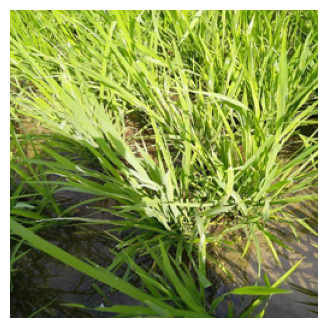

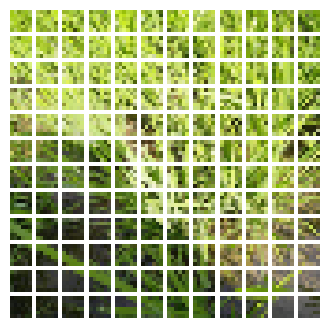

In [19]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Implementing the patch encoding layer**

In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**ViT Model**

In [21]:
def create_vit_classifier():
    
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Callback

In [27]:
filepath = HOME_PATH + 'paddy_models/model_vgg_new.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [28]:
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [29]:
# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [30]:
def train(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ]
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.3,
        callbacks=[checkpoint, reduce_lr, terminate_nan]
    )

    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 72, 72, 3) │          7 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 144, 64)   │     16,192 │ patches_2[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 144, 128)  │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 144, 64)   │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 144, 64)   │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 144, 64)   │          0 │ dropout_29[0][0], │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 144, 128)  │      8,320 │ layer_normalizat

 Total params: 21,666,769 (82.65 MB)

 Trainable params: 21,666,762 (82.65 MB)

 Non-trainable params: 7 (32.00 B)

In [31]:
history = train(vit_classifier)

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.1647 - loss: 3.9922
Epoch 1: val_accuracy improved from -inf to 0.26673, saving model to c:\Users\Admin\Desktop\COSC2753_A2_MachineLearning/paddy_models/model_vgg_new.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 122s 642ms/step - accuracy: 0.1649 - loss: 3.9853 - val_accuracy: 0.2667 - val_loss: 2.0816 - learning_rate: 0.0010
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.2501 - loss: 2.1435
Epoch 2: val_accuracy improved from 0.26673 to 0.33174, saving model to c:\Users\Admin\Desktop\COSC2753_A2_MachineLearning/paddy_models/model_vgg_new.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 96s 627ms/step - accuracy: 0.2502 - loss: 2.1433 - val_accuracy: 0.3317 - val_loss: 1.9000 - learning_rate: 0.0010
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.2767 - loss: 2.0216
Epoch 3: val_accuracy improved from 0.33174 to 0.34130, saving model to c:\Users\Admin\Desktop\COSC2753_A2_MachineLearning/paddy_models

In [33]:
vit_classifier.save_weights(HOME_PATH + '/paddy_models/vit.weights.h5')

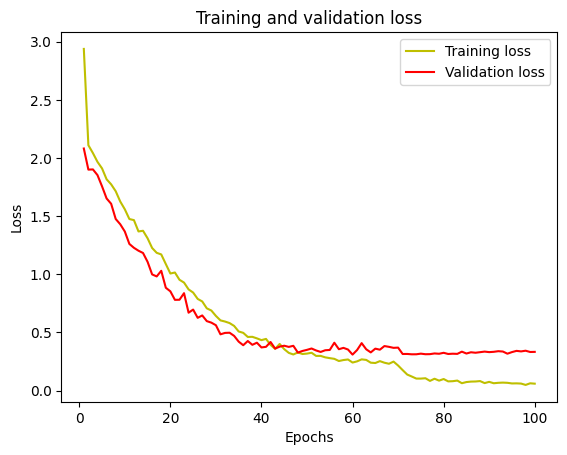

In [34]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

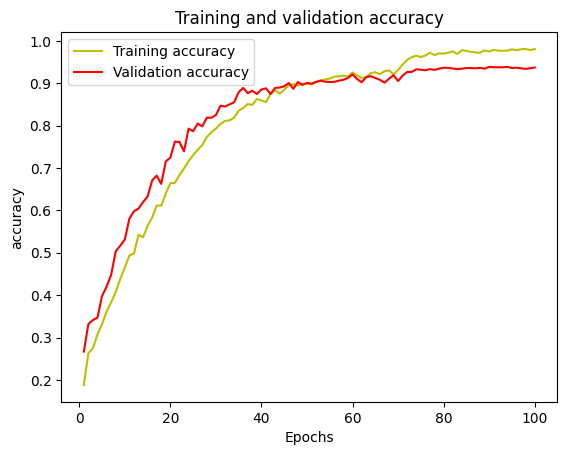

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Generate Prediction

In [ ]:
validation_ds = keras.utils.image_dataset_from_directory(
    directory=HOME_PATH + 'train_images',
    batch_size=16,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123 
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = HOME_PATH + 'test_images',
    batch_size = 16,
    image_size = (256, 256),
    label_mode = None,
    shuffle=False
)

# Predict the labels of the test set
predictions = vit_classifier.predict(test_ds)

predicted_labels = [labels[prediction.argmax()] for prediction in predictions]

loss, accuracy = vit_classifier.evaluate(validation_ds)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.
Found 3469 files.


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(16, 244, 244, 3)

In [ ]:
# Create a submission file
submission_df = pd.DataFrame({'image_id': test_ds.file_paths, 'label': predicted_labels})

submission_df['image_id'] = submission_df['image_id'].apply(lambda x: x.split('/')[-1])

submission_df.to_csv('sample_submission.csv', index=False)

In [ ]:
# Display unique predicted labels
print(set(predicted_labels))

# Display submission head
print(submission_df.head())